<!DOCTYPE html>
<html>
<head>
    <title>Cas d'étude</title>
</head>
<body>
    <h1>Contexte</h1>
    <p>Etude de la production mensuelle de bière en Australie entre janvier 1956 et fevrier 1991 à l’aide d’un modèle SARIMA</p>
</body>
</html>

# Packages

In [1]:
import pandas as pd
import numpy as np
# import statsmodels.api as sm
import statsmodels as sm

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

In [2]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

# Data preprocessing

## Importation and visualisation

In [2]:
# Import des données
data = pd.read_csv('data//beer.txt', sep=',', header=None, names=['x'])
plage_dates = pd.date_range(start='1956-01-01', end='1991-02-01', freq='MS')
data['month'] = plage_dates
data.columns = ['prod', 'month']
data = data[['month', 'prod']]

Text(0.5, 1.0, 'Série temporelle')

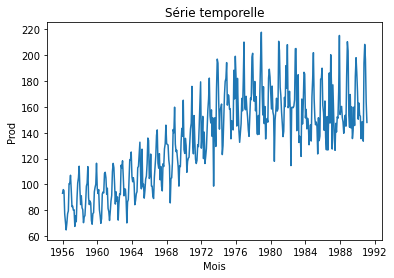

In [3]:
# Visualiser les données temporelles
import matplotlib.pyplot as plt
plt.plot(data['month'], data['prod'])
plt.xlabel('Mois')
plt.ylabel('Prod')
plt.title('Série temporelle')

In [4]:
data

,month,prod
0,1956-01-01,93.2
1,1956-02-01,96.0
2,1956-03-01,95.2
3,1956-04-01,77.1
4,1956-05-01,70.9
...,...,...
417,1990-10-01,193.8
418,1990-11-01,208.4
419,1990-12-01,197.0
420,1991-01-01,164.0


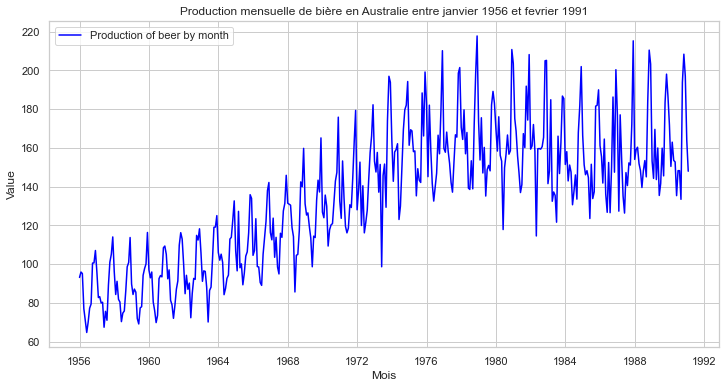

In [5]:
# Assuming df is your DataFrame
sns.set(style="whitegrid") # Setting the style to whitegrid for a clean background

plt.figure(figsize=(12, 6)) # Setting the figure size
sns.lineplot(data=data, x='month', y='prod', label='Production of beer by month', color='blue')

# Adding labels and title
plt.xlabel('Mois')
plt.ylabel('Value')
plt.title('Production mensuelle de bière en Australie entre janvier 1956 et fevrier 1991')

plt.show()

Le graphe ci-dessus montre deux tendances dans les données.

## Tendance

Dans cette partie, nous allons une étude de la tendance.

La fonction `detrend` supprime la tendance de la série. Elle ajuste d'abord une regression sur les données pour détecter la tendance. Ensuite, elle supprime cette partie de la série. Les étapes sont les suivantes :
1. Soit $y(t)$ une série temporelle à un instant $t$.
2. On ajuste un modèle de régression linéaire à $y(t)$ en fonction du temps t. Cela peut être fait en trouvant les coefficients $\beta_0$(ordonnée à l'origine) et $\beta_1$ (pente) tels que la somme des carrés des résidus soit minimisée.
3. Une fois le modèle ajusté, la tendance $\hat{y}(t)$ est estimée en utilisant la formule de la droite de régression : $\hat{y}(t) = \beta_0 + \beta_1t$
4. Enfin, pour supprimer la tendance, nous soustrayons la tendance estimée de la série temporelle d'origine : $y_{notrend} = y - \hat{y}$

<AxesSubplot:xlabel='month'>

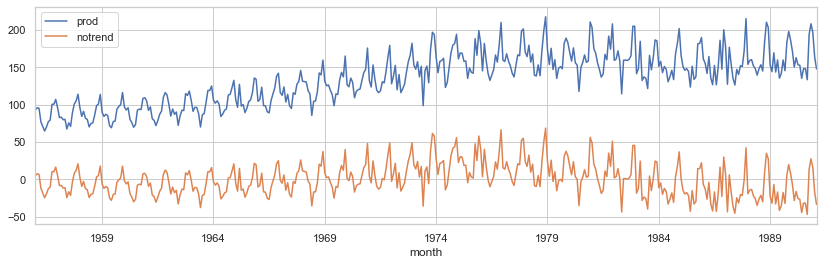

In [7]:
from statsmodels.tsa.tsatools import detrend

notrend = detrend(data['prod'])
data["notrend"] = notrend
data.plot(x="month", y=["prod", "notrend"], figsize=(14,4))

## Saisonality

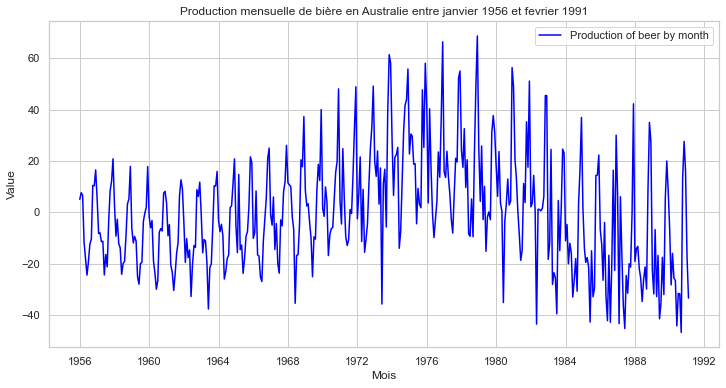

In [8]:
# Assuming df is your DataFrame
sns.set(style="whitegrid") # Setting the style to whitegrid for a clean background

plt.figure(figsize=(12, 6)) # Setting the figure size
sns.lineplot(data=data, x='month', y='notrend', label='Production of beer by month', color='blue')

# Adding labels and title
plt.xlabel('Mois')
plt.ylabel('Value')
plt.title('Production mensuelle de bière en Australie entre janvier 1956 et fevrier 1991')

In [9]:
data['Date'] = pd.to_datetime(data['month'])
data.set_index('Date', inplace=True)
# data_monthly = data.resample('M').mean()

In [10]:
yrs = [str(yr) for yr in data.index.year.unique()]
mths = data.index.month_name().unique()

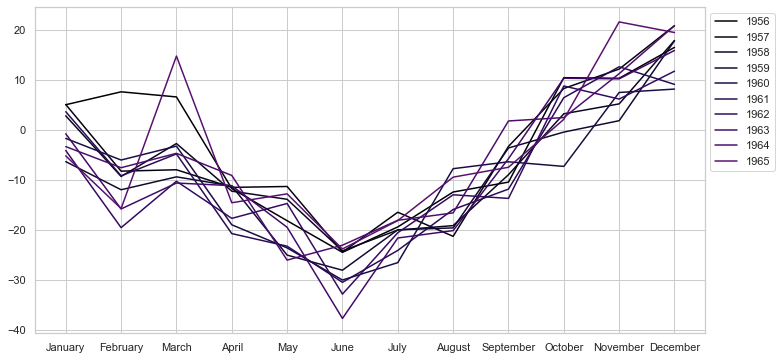

In [11]:
plt.figure(figsize=(12, 6))

colors = plt.cm.inferno(np.linspace(0, 1, len(yrs)))

for i in range(10):
    plt.plot(mths, data[yrs[i]]['notrend'], label=yrs[i], color=colors[i])
    plt.legend(bbox_to_anchor=(1,1))

En l’absence d’effet saisonnier, les 12 chronogrammes mensuels seraient à peu près identiques, ce qui n’est pas le cas ici. On remarque notamment que la production mensuelle de bière est à son niveau le plus bas au mois de juin (début de l’été), elle est à son maximum au mois de décembre. Ainsi, nous pouvons espérer modéliser la série par un SARIMA.

Text(0.5, 1.0, "Fonction d'autocorrélation (ACF)")

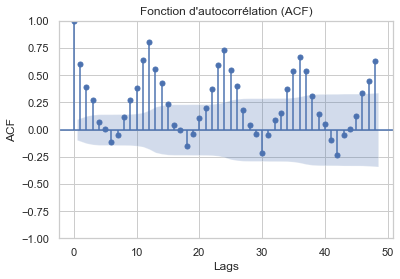

In [13]:
from statsmodels.graphics.tsaplots import plot_acf


plot_acf(data.notrend, lags = 48)
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.title('Fonction d\'autocorrélation (ACF)')

La forme de l’acf confirme l’effet saisonnier de la série. On note une décroissance lente vers 0 pour les multiples de 12.

Nous allons effectuer une différentitation saisonnière $(I-B^{12})$.

In [18]:
y = data.notrend
y_diff_12 = y - y.shift(12)
data['no_saisonnality'] = y_diff_12

Text(0.5, 1.0, 'Production mensuelle de bière en Australie entre janvier 1956 et fevrier 1991')

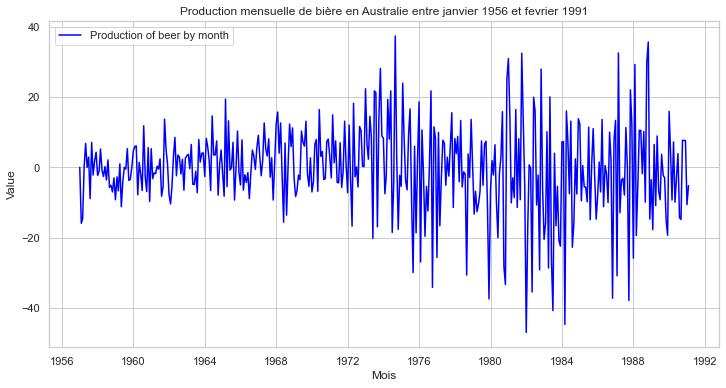

In [19]:
# Assuming df is your DataFrame
sns.set(style="whitegrid") # Setting the style to whitegrid for a clean background

plt.figure(figsize=(12, 6)) # Setting the figure size
sns.lineplot(data=data, x='month', y='no_saisonnality', label='Production of beer by month', color='blue')

# Adding labels and title
plt.xlabel('Mois')
plt.ylabel('Value')
plt.title('Production mensuelle de bière en Australie entre janvier 1956 et fevrier 1991')

Text(0.5, 1.0, "Fonction d'autocorrélation (ACF)")

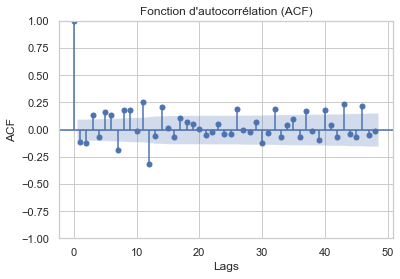

In [16]:
plot_acf(y_diff_12[12:], lags = 48)
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.title('Fonction d\'autocorrélation (ACF)')

Text(0.5, 1.0, "Fonction d'autocorrélation (ACF)")

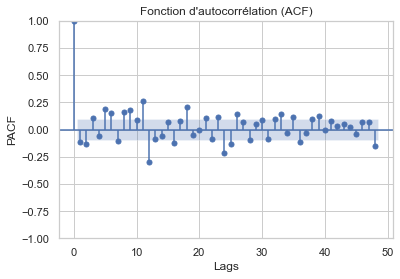

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(y_diff_12[12:], lags = 48)
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.title('Fonction d\'autocorrélation (ACF)')

# Modélisation

## Identification

Text(0.5, 1.0, "Fonction d'autocorrélation partielle (PACF)")

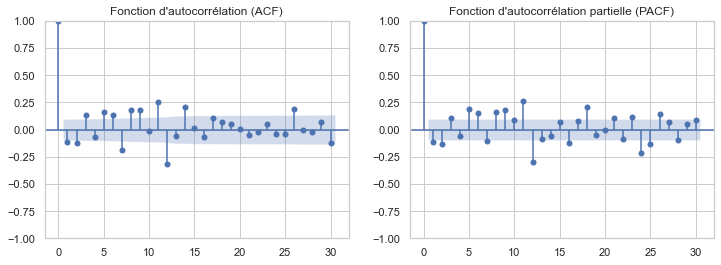

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Crée une figure avec deux sous-graphiques côte à côte

plot_acf(y_diff_12[12:], lags=30, ax=axes[0])  # Affiche l'ACF dans le premier sous-graphique
axes[0].set_title('Fonction d\'autocorrélation (ACF)')

plot_pacf(y_diff_12[12:], lags=30, ax=axes[1])  # Affiche le PACF dans le deuxième sous-graphique
axes[1].set_title('Fonction d\'autocorrélation partielle (PACF)')

Les graphiques ACF et PACF permettent de voir empiriquement qu'on va voir un modèle $SARIMA(p,d,q)(P,D,Q)_s$, avec $s=12$

## Estimation and Validation